# LSC Notebook

## LSC studies

In [1]:
import time

In [2]:
from __future__ import print_function

In [3]:
%matplotlib inline

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import tables as tb
import numpy as np
import mplFunctions as mpl
import wfmFunctions as wfm
import sensorFunctions as snf
from Util import *
import FEParam as FP
from scipy import signal as SGN

In [7]:
%env PYTHONPATH

'/home/icuser/IC:/home/icuser/IC/Cities:/home/icuser/IC/Notebooks:/home/icuser/IC/Utilities:/home/icuser/IC/Sierpe:/home/icuser/IC/Core'

In [8]:
import logging
import sys
logger = logging.getLogger()
logger.handlers[0].stream = sys.stdout
logger.setLevel(logging.DEBUG)

In [9]:
print(time.strftime("%d/%m/%Y"))
print(time.strftime("%H:%M:%S"))

08/10/2016
11:48:27


### Access to LSC

### Script DAQ to h5

In [13]:
!ls -lh ../../../waveforms/hdf5/*2308*.h5

-rw-rw-r-- 1 icuser icuser 164M Oct  7 14:18 ../../../waveforms/hdf5/run_2308.gdc1next.000.next1el_2308.root.h5
-rw-rw-r-- 1 icuser icuser 164M Oct  7 14:19 ../../../waveforms/hdf5/run_2308.gdc1next.001.next1el_2308.root.h5
-rw-rw-r-- 1 icuser icuser  52M Oct  7 14:20 ../../../waveforms/hdf5/run_2308.gdc1next.002.next1el_2308.root.h5
-rw-rw-r-- 1 icuser icuser  89M Oct  7 14:20 ../../../waveforms/hdf5/run_2308.gdc1next.003.next1el_2308.root.h5
-rw-rw-r-- 1 icuser icuser 1.7M Oct  7 14:20 ../../../waveforms/hdf5/run_2308.gdc1next.004.next1el_2308.root.h5
-rw-rw-r-- 1 icuser icuser  72M Oct  7 14:21 ../../../waveforms/hdf5/run_2308.gdc1next.005.next1el_2308.root.h5
-rw-rw-r-- 1 icuser icuser 103M Oct  7 14:22 ../../../waveforms/hdf5/run_2308.gdc1next.006.next1el_2308.root.h5
-rw-rw-r-- 1 icuser icuser  13M Oct  7 14:22 ../../../waveforms/hdf5/run_2308.gdc1next.007.next1el_2308.root.h5
-rw-rw-r-- 1 icuser icuser 164M Oct  7 14:23 ../../../waveforms/hdf5/run_2308.gdc1next.008.next1el_2308.

## October Argon run

In [14]:
def get_vectors(h5f):
    """
    input: file pointer
    returns: data vectors
    """
    pmtrwf = h5f.root.RD.pmtrwf
    sipmrwf = h5f.root.RD.sipmrwf
    geom_t = h5f.root.Detector.DetectorGeometry
    pmt_t = h5f.root.Sensors.DataPMT
    sipm_t = h5f.root.Sensors.DataSiPM
    gdf = snf.read_data_geom(geom_t)
    pmtdf = snf.read_data_sensors(pmt_t)
    sipmdf = snf.read_data_sensors(sipm_t)
    return pmtrwf,sipmrwf,pmtdf,sipmdf,gdf
    

In [15]:
def wfdf(time,energy_pes,indx):
    """
    takes three vectors (time, energy and indx) and returns a data frame representing a waveform
    """
    swf = {}
    swf['time_mus'] = time/mus
    swf['ene_pes'] = energy_pes 
    swf['indx'] = indx
    return pd.DataFrame(swf)

In [16]:
def waveform_panel(pmtrwf,pmtdf,mau_len = 500, calib_constat =True, adc_to_pes=20, 
                   type = 'PMT', daq_ceiling=4096, event=0):
    """
    input: sensor (pmt or sipm) data vector, sensor data frame (position, calibration)
    returns: a panel holding waveforms for all sensors, and a series for the baselines
    """
    PMT = {}
    nm = mau_len
    B_MAU = (1./nm)*np.ones(nm)
    pmt_len = pmtrwf.shape[2]
    NPMT = pmtrwf.shape[1]
    MAU = np.zeros(nm)
    BSL = {}
    
    time_ns = np.arange(pmt_len)*mus
    indx = np.arange(pmt_len)
    
    if type == 'PMT':
        time_ns = np.arange(pmt_len)*FP.time_DAQ
        
    ene_sum = 0
    for j in range(NPMT):
                     
        if calib_constat == True:
            adc_to_pes = abs(pmtdf['adc_to_pes'][j])
            
        signal_daq = pmtrwf[event,j]
        if type == 'PMT':
            signal_daq = daq_ceiling - pmtrwf[event,j]
            
        MAU[0:nm] = SGN.lfilter(B_MAU,1, signal_daq[0:nm])
        BASELINE = MAU[nm-1]
        
        ene_pes = (signal_daq - BASELINE)/adc_to_pes
        if type == 'PMT':
            ene_sum += ene_pes
            
        PMT[j] = wfdf(time_ns,ene_pes,indx)
        BSL[j] = BASELINE
    PMT[j+1] = wfdf(time_ns,ene_sum,indx)
    return pd.Panel(PMT),pd.Series(BSL)


In [17]:
def plot_PPMT(pmt_panel, tmin=0, tmax=1200, emin = 0, emax = 10000, option='sum'):
    """
    Plots pmtwf
    """
    plt.figure(figsize=(10,10))
    
    if option == 'sum':
        ax1 = plt.subplot(1,1,1)
        ax1.set_xlim([tmin, tmax])
        ax1.set_ylim([emin, emax])
        indx = pmt_panel.items[-1]
        pmtwf = pmt_panel[indx]
        plt.plot(pmtwf['time_mus'],pmtwf['ene_pes'])
    else:
        
        for i in pmt_panel.items[0:-1]:
            ax1 = plt.subplot(3,4,int(i)+1)
            ax1.set_xlim([tmin, tmax])
            ax1.set_ylim([emin, emax])
        
            pmtwf = pmt_panel[i]
            plt.plot(pmtwf['time_mus'],pmtwf['ene_pes'])
    
    plt.show()

In [18]:
def wf_thr(wf,threshold=0):
    """
    return a zero supressed waveform (more generally, the vaules of wf above threshold)
    """
    return wf.loc[lambda df: df.ene_pes.values >threshold, :]

In [19]:
def energy_sum(sensor_panel, thr=0):
    """
    Sum the WFs of PMTs and SiPMs (MC) and store the total energy in PES
    """     
    EPES = []

    for i in sensor_panel.items[0:-1]:
        pmtwf = sensor_panel[i]
        EPES.append(np.sum(pmtwf.ene_pes.values[np.where(pmtwf.ene_pes.values>thr)]))
    return pd.Series(EPES) 

In [20]:
def plot_sensors(geom_df,sensor_df, energy, radius=10):
    """
    plots the energy of the sensors 
    """
    x =sensor_df['x'].values
    y =sensor_df['y'].values
    r =np.ones(len(sensor_df['x'].values))*radius
    
    plt.figure(figsize=(10,10))
    ax = plt.subplot(aspect='equal')
    mpl.circles(x, y, r, c=energy, alpha=0.5, ec='none')
    plt.colorbar()
    
    plt.xlim(geom_df['xdet_min'],geom_df['xdet_max'])
    plt.ylim(geom_df['ydet_min'],geom_df['ydet_max'])
    

In [21]:
def find_S12(swf, stride=40):
    """
    Find S1 or S2 signals. The input is a zero-supressed WF. The stride defines the contiguity criterium.
    The stride is applied to the indexes which keep the ordering of the original (non-zs) WF. 
    For example, with a stride of 40 (corresponding to steps of 1 mus for a DAQ timing of 25 ns) index 1
    and index 39 are in the same S12. 
    """
    T = swf['time_mus'].values
    P = swf['ene_pes'].values
    I = swf['indx'].values
    
    S12 = {}
    pulse_on = 1
    j=0
    
    S12[0] = []
    S12[0].append([T[0],P[0],I[0]])
    
    for i in range(1,len(swf)) :
        if swf.index[i]-stride > swf.index[i-1]:  #new s12
            j+=1
            S12[j] = []
            S12[j].append([T[i],P[i],I[i]])
        else:
            S12[j].append([T[i],P[i],I[i]])
            
    S12L=[]
    for i in S12.keys():
        S12L.append(pd.DataFrame(S12[i], columns=['time_mus','ene_pes','indx']))
    return S12L

In [22]:
def rebin_waveform(swf, stride = 40):
    """
    rebins the a waveform according to stride 
    The input waveform is a vector such that the index expresses time bin and the
    contents expresses energy (e.g, in pes)
    The function returns a DataFrame. The time bins and energy are rebinned according to stride
    """
    
    t = swf['time_mus'].values
    e = swf['ene_pes'].values
    I = swf['indx'].values
    n = len(swf)/int(stride)
    r = len(swf)%int(stride)
    
    lenb = n
    if r > 0: 
        lenb = n+1
    
    T = np.zeros(lenb)
    E = np.zeros(lenb)
    II = np.zeros(lenb, dtype=int)
    
    j=0
    for i in range(n):
        E[i] = np.sum(e[j:j+stride])
        T[i] = np.mean(t[j:j+stride])
        II[i] = I[(j+stride)/2]
        j+= stride
        
    if r > 0:
        E[n] = np.sum(e[j:])
        T[n] = np.mean(t[j:])
        II[n] = I[(len(swf) - j/2)]
    
   
    rbw={}
    rbw['ene_pes'] = E
    rbw['time_mus'] = T
    rbw['indx'] = II
    return pd.DataFrame(rbw)

In [23]:
def find_t0(s1):
    """
    returns t0
    """
    emax = np.amax(s1.ene_pes.values)
    return s1.loc[lambda df: df.ene_pes.values ==emax, :]

In [24]:
def s2_energy(s2):
    """
    total energy in pes
    """
    return np.sum(s2.ene_pes.values)

In [25]:
def s2_length(s2):
    """
    s2 length in mus
    """
    t = s2.time_mus.values
    return t[-1] - t[0]

In [26]:
def s2_peak(s2):
    """
    s2 peak in mus
    """
        
    return s2rb.describe().time_mus['max'], s2rb.describe().ene_pes['max']

In [27]:
def find_t(s1,s2):
    """
    returns the time of the interaction
    """
    t0 = find_t0(s1).time_mus.values[0]
    ts2,es2 = s2_peak(s2)
    return ts2 - t0
        

In [28]:
def sipm_s2(sipmdf, s2df):
    """
    Takes a sipm DF and an s2df
    Returns a DF with the sipm values in the range specified by s2
    """
    s2ti = s2df.time_mus.values[0]
    s2tf = s2df.time_mus.values[-1]
    dfl = sipmdf.loc[lambda df: df.time_mus.values >= s2ti, :]
    dfu = dfl.loc[lambda df: df.time_mus.values < s2tf, :]
    return dfu

In [29]:
def sipm_s2_panel(sipmp, s2, thr_min=0.5, thr_s2 =1, event_number=0):
    """
    Takes a sipmp
    Returns a sipm panel with a collection of sipm DF such that:
    1. the range of the sipm is specified by s2
    2. the sipm energy are above threshold.
    """
    
    j=0
    SIPM={}
    ESIPM=[]
    for i in (sipmp.items):
        sipm = sipmp[i]
        ESIPM.append(np.sum(sipm.ene_pes))
        
        if np.sum(sipm.ene_pes) < thr_min:  #only worry about SiPM with energy above threshold
            continue
            
        sipms2 = sipm_s2(sipm, s2)
        if np.sum(sipms2).ene_pes > thr_s2:
            SIPM[j] = sipms2
            j+=1
    return pd.Panel(SIPM), np.array(ESIPM)
 

In [30]:
def sipm_s2_energy(sipmp, s2, thr_min=0.5, thr_s2 =0.5):
    """
    Takes a sipmp
    Returns a sipm panel where every member is a SiPM which has energy above trheshold:
    The energy of the SiPM corresponds to the S2 width

    """
    
    j=0
    SIPM={}
    for i in (sipmp.items):
        sipm = sipmp[i]
        etot = np.sum(sipm.ene_pes)
        if etot < thr_min:  #only worry about SiPM with energy above threshold
            continue
            
        sipms2 = sipm_s2(sipm, s2)
        es2 = np.sum(sipms2).ene_pes
        if es2 > thr_s2:
            DATA = []
            DATA.append(i)
            DATA.append(etot)
            DATA.append(es2)
            SIPM[j] = DATA
            j+=1
    return pd.DataFrame(data=SIPM.values(), index=SIPM.keys(), columns=['sipm_indx','etot_pes','es2_pes'])

In [31]:
def sPMT(pmt_panel):
    return pmt_panel[PMT.items[-1]]

### RUN 2297

In [32]:
%ls -lh ../../../waveforms/hdf5/*2308*.h5

-rw-rw-r-- 1 icuser icuser 164M Oct  7 14:18 ../../../waveforms/hdf5/run_2308.gdc1next.000.next1el_2308.root.h5
-rw-rw-r-- 1 icuser icuser 164M Oct  7 14:19 ../../../waveforms/hdf5/run_2308.gdc1next.001.next1el_2308.root.h5
-rw-rw-r-- 1 icuser icuser  52M Oct  7 14:20 ../../../waveforms/hdf5/run_2308.gdc1next.002.next1el_2308.root.h5
-rw-rw-r-- 1 icuser icuser  89M Oct  7 14:20 ../../../waveforms/hdf5/run_2308.gdc1next.003.next1el_2308.root.h5
-rw-rw-r-- 1 icuser icuser 1.7M Oct  7 14:20 ../../../waveforms/hdf5/run_2308.gdc1next.004.next1el_2308.root.h5
-rw-rw-r-- 1 icuser icuser  72M Oct  7 14:21 ../../../waveforms/hdf5/run_2308.gdc1next.005.next1el_2308.root.h5
-rw-rw-r-- 1 icuser icuser 103M Oct  7 14:22 ../../../waveforms/hdf5/run_2308.gdc1next.006.next1el_2308.root.h5
-rw-rw-r-- 1 icuser icuser  13M Oct  7 14:22 ../../../waveforms/hdf5/run_2308.gdc1next.007.next1el_2308.root.h5
-rw-rw-r-- 1 icuser icuser 164M Oct  7 14:23 ../../../waveforms/hdf5/run_2308.gdc1next.008.next1el_2308.

In [39]:
h5f =tb.open_file('../../../waveforms/hdf5/run_2308.gdc1next.000.next1el_2308.root.h5')

HDF5ExtError: HDF5 error back trace

  File "H5F.c", line 604, in H5Fopen
    unable to open file
  File "H5Fint.c", line 1087, in H5F_open
    unable to read superblock
  File "H5Fsuper.c", line 277, in H5F_super_read
    file signature not found

End of HDF5 error back trace

Unable to open/create file '../../../waveforms/hdf5/run_2308.gdc1next.002.next1el_2308.root.h5'

In [37]:
h5f

File(filename=../../../waveforms/hdf5/run_2308.gdc1next.001.next1el_2308.root.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
  description := {
  "x_det": Float32Col(shape=(2,), dflt=0.0, pos=0),
  "y_det": Float32Col(shape=(2,), dflt=0.0, pos=1),
  "z_det": Float32Col(shape=(2,), dflt=0.0, pos=2),
  "r_det": Float32Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (2340,)
/RD (Group) ''
/RD/pmtrwf (EArray(335, 12, 40000), zlib(1)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 1, 32768)
/RD/sipmrwf (EArray(335, 256, 1000), zlib(1)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 50, 1000)
/Sensors (Group) ''
/Sensors/DataPMT (Table(12,)) ''
  descripti

In [38]:
h5f.close()

In [29]:
pmtrwf,sipmrwf,pmtdf,sipmdf,gdf = get_vectors(h5f)

In [30]:
PMT, BSL  = waveform_panel(pmtrwf,pmtdf,calib_constat =True, type = 'PMT', event=0)

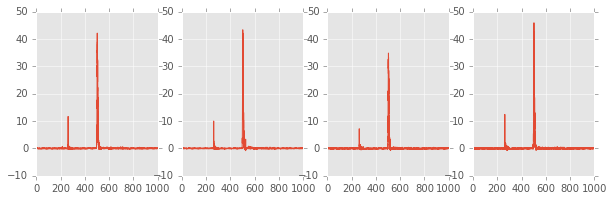

In [31]:
plot_PPMT(PMT, tmin=0, tmax=1000, emin = -10, emax = 50, option='all')

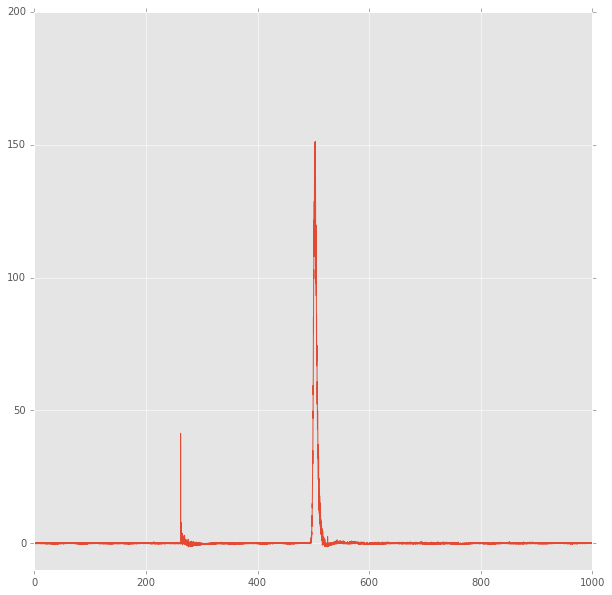

In [32]:
plot_PPMT(PMT, tmin=0, tmax=1000, emin = -10, emax = 200, option='sum')

In [33]:
PMT.items

Int64Index([0, 1, 2, 3, 4], dtype='int64')

In [35]:
wf_zs = wf_thr(sPMT(PMT),threshold=6)

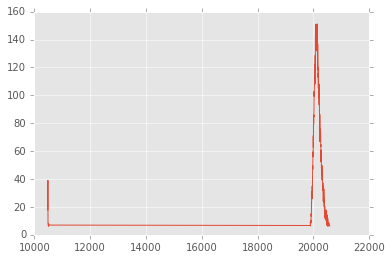

In [36]:
plt.plot(wf_zs.ene_pes)

In [37]:
s12 = find_S12(wf_zs)

In [38]:
len(s12)

2

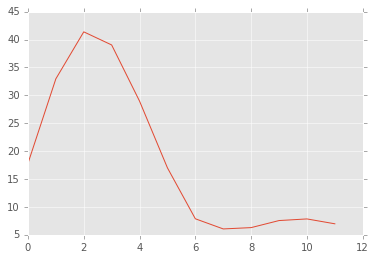

In [39]:
plt.plot(s12[0].ene_pes)

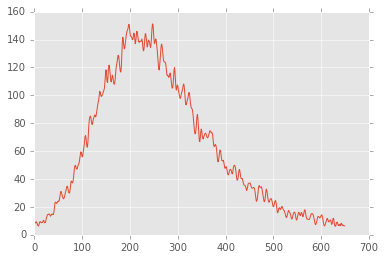

In [40]:
plt.plot(s12[1].ene_pes)

In [41]:
s1 = s12[0]

In [42]:
s2 = s12[1]

In [43]:
s2rb = rebin_waveform(s2, stride = 40)

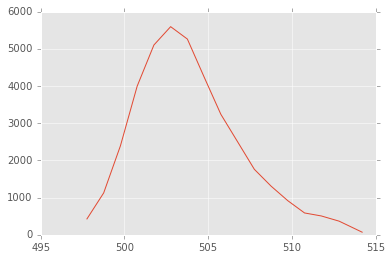

In [44]:
plt.plot(s2rb['time_mus'], s2rb['ene_pes'])

In [45]:
print("ene s2 = {} pes; ene s2rb = {} pes (must be the same)".format(np.sum(s2.ene_pes.values), 
                                                                     np.sum(s2rb.ene_pes.values)))

ene s2 = 39394.8933601 pes; ene s2rb = 39394.8933601 pes (must be the same)


In [46]:
print("t0 = {} mus".format(find_t0(s1).time_mus.values[0]))

t0 = 262.15 mus


In [47]:
s2rb.describe()

ene_pes          indx    time_mus
count    17.000000     17.000000   17.000000
mean   2317.346668  20070.411765  505.792022
std    1903.553083    100.029407    5.099564
min      70.429598  19911.000000  497.762500
25%     586.968513  19991.000000  501.762500
50%    1760.439804  20071.000000  505.762500
75%    3995.003128  20151.000000  509.762500
max    5595.159821  20221.000000  514.202500

In [48]:
s2rb.describe().ene_pes

count      17.000000
mean     2317.346668
std      1903.553083
min        70.429598
25%       586.968513
50%      1760.439804
75%      3995.003128
max      5595.159821
Name: ene_pes, dtype: float64

In [49]:
s2rb.describe().ene_pes['max']

5595.1598205566406

In [50]:
ts2, emaxs2 = s2_peak(s2)

In [51]:
print("ts2 = {} mus, emax = {} pes".format(ts2,emaxs2))

ts2 = 514.2025 mus, emax = 5595.15982056 pes


In [52]:
print('tint = {} mus '.format(find_t(s1,s2)))

tint = 252.0525 mus 


### SiPMs

In [131]:
SIPM, SIBSL  = waveform_panel(sipmrwf,sipmdf,mau_len = 100, calib_constat =False, adc_to_pes=20, type = 'SIPM', event=0)

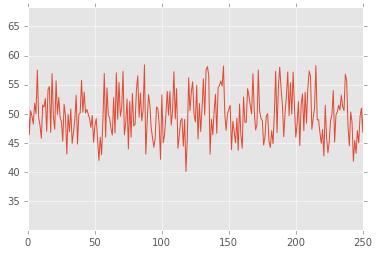

In [132]:
mpl.plts(SIBSL, signal_start=0, signal_end=250, offset=10)

In [133]:
SIBSL.describe()

count    256.000000
mean      49.987266
std        3.973787
min       40.140000
25%       46.982500
50%       49.780000
75%       52.950000
max       58.410000
dtype: float64

In [134]:
SIPM

<class 'pandas.core.panel.Panel'>
Dimensions: 257 (items) x 1000 (major_axis) x 3 (minor_axis)
Items axis: 0 to 256
Major_axis axis: 0 to 999
Minor_axis axis: ene_pes to time_mus

In [183]:
esipmdf = sipm_s2_energy(SIPM, s2, thr_min=25, thr_s2 =2.0)

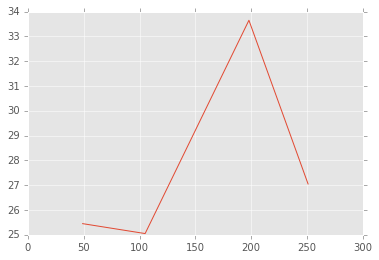

In [144]:
plt.plot(esipmdf.sipm_indx,esipmdf.etot_pes)

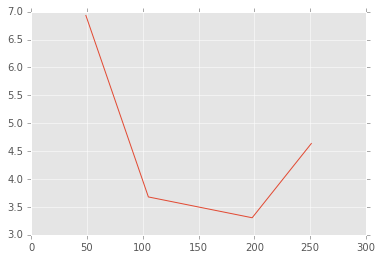

In [145]:
plt.plot(esipmdf.sipm_indx,esipmdf.es2_pes)

In [146]:
esipmdf

sipm_indx   etot_pes   es2_pes
0         49  25.450031  6.931001
1        105  25.049954  3.678499
2        198  33.650091  3.305502
3        251  27.049993  4.636000

In [156]:
epmt = energy_sum(PMT, thr=0)

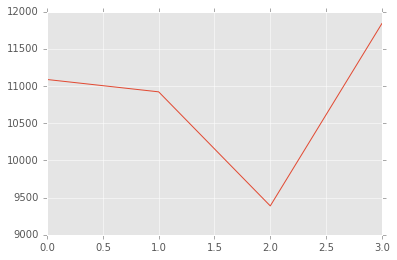

In [157]:
plt.plot(epmt)

In [158]:
esipm = energy_sum(SIPM, thr=0)

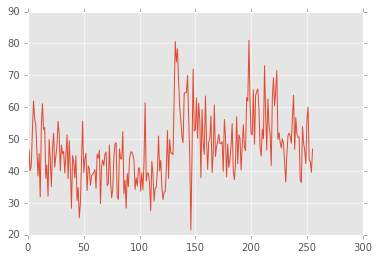

In [159]:
plt.plot(esipm)

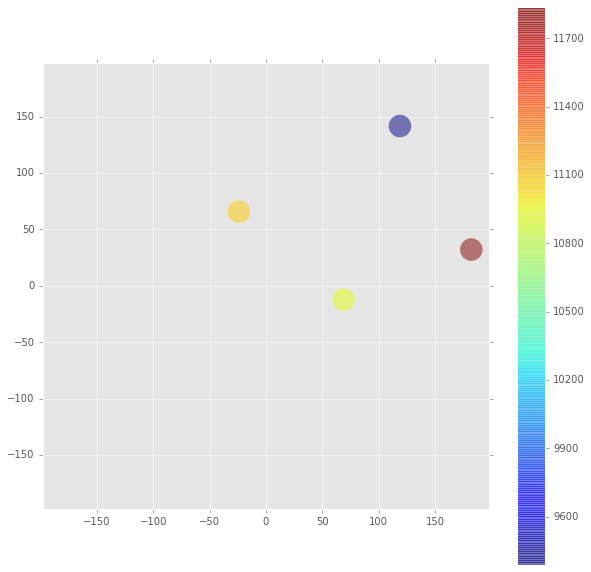

In [160]:
plot_sensors(gdf,pmtdf, epmt, radius=10)

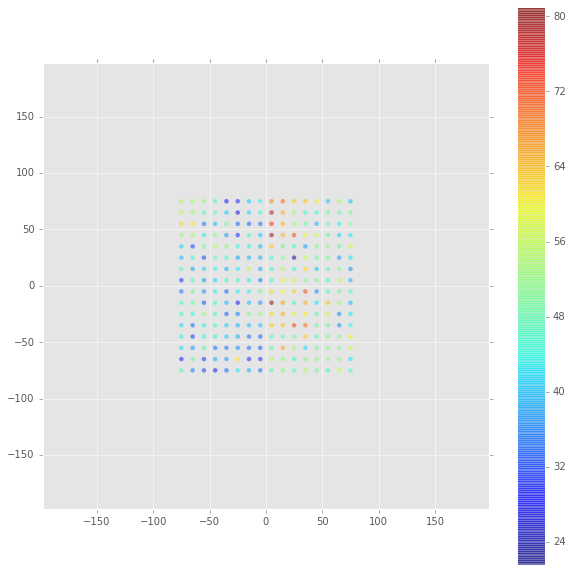

In [161]:
plot_sensors(gdf,sipmdf, esipm, radius=2)

In [162]:
PMT, BSL  = waveform_panel(pmtrwf,pmtdf,calib_constat =True, type = 'PMT', event=1)

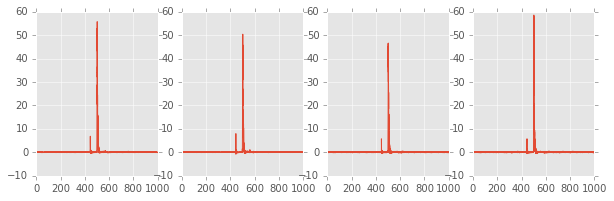

In [165]:
plot_PPMT(PMT, tmin=0, tmax=1000, emin = -10, emax = 60, option='all')

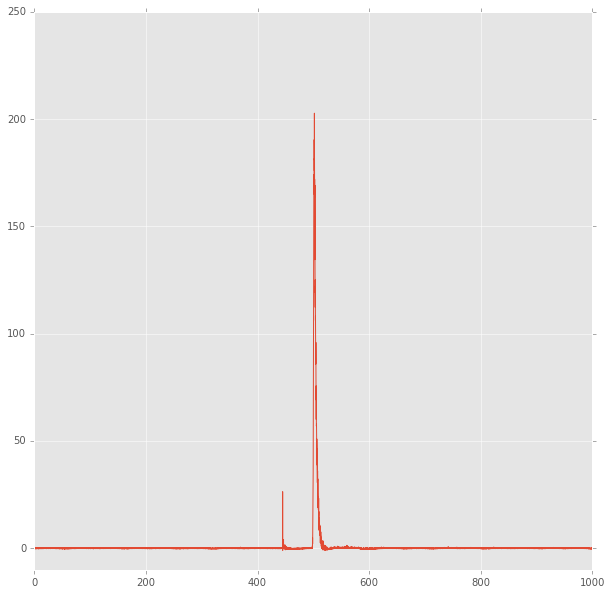

In [166]:
plot_PPMT(PMT, tmin=0, tmax=1000, emin = -10, emax = 250, option='sum')

In [167]:
wf_zs = wf_thr(sPMT(PMT),threshold=6)

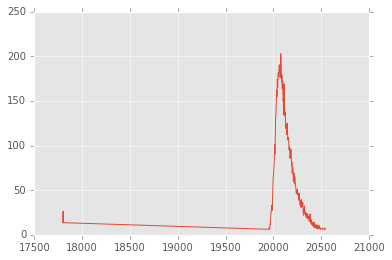

In [168]:
plt.plot(wf_zs.ene_pes)

In [169]:
s12 = find_S12(wf_zs)

In [170]:
len(s12)

2

In [171]:
s1 = s12[0]
s2 = s12[1]

In [172]:
s2rb = rebin_waveform(s2, stride = 40)

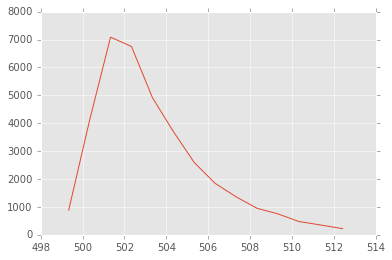

In [173]:
plt.plot(s2rb['time_mus'], s2rb['ene_pes'])

In [174]:
print("ene s2 = {} pes; ene s2rb = {} pes (must be the same)".format(np.sum(s2.ene_pes.values), 
                                                                     np.sum(s2rb.ene_pes.values)))

ene s2 = 35999.8014841 pes; ene s2rb = 35999.8014841 pes (must be the same)


In [175]:
print("t0 = {} mus".format(find_t0(s1).time_mus.values[0]))

t0 = 445.025 mus


In [176]:
ts2, emaxs2 = s2_peak(s2)

In [177]:
print("ts2 = {} mus, emax = {} pes".format(ts2,emaxs2))

ts2 = 512.428448276 mus, emax = 7083.81370544 pes


In [178]:
print('tint = {} mus '.format(find_t(s1,s2)))

tint = 67.4034482759 mus 


In [180]:
SIPM, SIBSL  = waveform_panel(sipmrwf,sipmdf,mau_len = 100, calib_constat =False, adc_to_pes=20, type = 'SIPM', event=1)

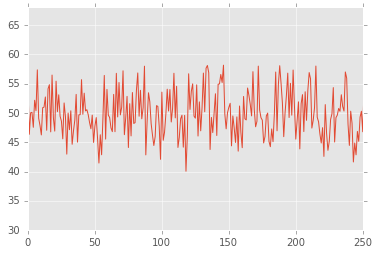

In [181]:
mpl.plts(SIBSL, signal_start=0, signal_end=250, offset=10)

In [186]:
esipmdf = sipm_s2_energy(SIPM, s2, thr_min=0, thr_s2 =0)

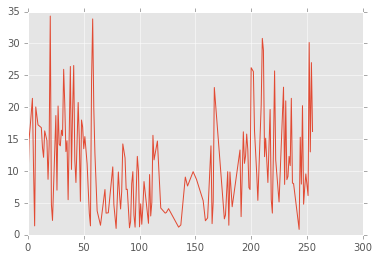

In [187]:
plt.plot(esipmdf.sipm_indx,esipmdf.etot_pes)

## BLR

1. Scale is wrong
2. Only 6 PMTs written
3. PMTRD field is not correct. Must be PMTRWF (in folder RD)

In [ ]:
class SBLR:
    """
    Signals BLR: a simple class to hold of the signals relevant for BLR
    """
    def __init__(self, len_signal_daq):
        """
        len_signal_daq: length of the signal to deconvolute
        
        
        """
        
        self.MAU = np.zeros(len_signal_daq, dtype=np.double)
        self.acum = np.zeros(len_signal_daq, dtype=np.double)
        self.signal_r = np.zeros(len_signal_daq, dtype=np.double)
        self.pulse_on = np.zeros(len_signal_daq, dtype=np.double)
        self.wait_over = np.zeros(len_signal_daq, dtype=np.double)
        self.offset = np.zeros(len_signal_daq, dtype=np.double)
        self.BASELINE = 0
        

def BLR(signal_daq, coef, mau_len=250, thr1 = 3*FP.NOISE_ADC, thr2 = FP.NOISE_ADC, 
        thr3 = FP.NOISE_ADC, log='INFO'):

    """
    Deconvolution offline of the DAQ signal using a MAU
    moving window-average filter of a vector data. See notebook 
    y(n) = (1/WindowSize)(x(n) + x(n-1) + ... + x(n-windowSize))
    in a filter operation filter(b,a,x):
    b = (1/WindowSize)*ones(WindowSize) = (1/WS)*[1,1,1,...]: numerator
    a = 1 : denominator
    y = filter(b,a,x)
    y[0] = b[0]*x[0] = (1/WS) * x[0]
    y[1] = (1/WS) * (x[0] + x[1])
    y[WS-1] = mean(x[0:WS])
    y[WS] = mean(x[1:WS+1])
    and so on
    """
    
    lg = 'logging.'+log
    logger.setLevel(eval(lg))
    len_signal_daq = len(signal_daq)
    sblr = SBLR(len_signal_daq)

    signal_i = np.copy(signal_daq) #uses to update MAU while procesing signal
    nm = mau_len
    B_MAU = (1./nm)*np.ones(nm)

#   MAU averages the signal in the initial tranch 
#    allows to compute the baseline of the signal  
    
    sblr.MAU[0:nm] = SGN.lfilter(B_MAU,1, signal_daq[0:nm])
    sblr.acum[nm] =  sblr.MAU[nm]
    sblr.BASELINE = sblr.MAU[nm-1]

    logging.debug("""-->BLR: 
                     MAU_LEN={}
                     thr1 = {}, thr2 = {}, thr3 = {} =""".format(
                     mau_len, thr1, thr2, thr3))
    logging.debug("n = {}, acum[n] = {} BASELINE ={}".format(nm, sblr.acum[nm],sblr.BASELINE))

#----------

# While MAU inits BLR is switched off, thus signal_r = signal_daq 

    sblr.signal_r[0:nm] = signal_daq[0:nm] 
    pulse_on=0
    wait_over=0
    offset = 0
    
    # MAU has computed the offset using nm samples
    # now loop until the end of DAQ window

    logging.debug("nm = {}".format(nm))
    
    for k in range(nm,len_signal_daq): 

        trigger_line = sblr.MAU[k-1] + thr1
        sblr.pulse_on[k] = pulse_on
        sblr.wait_over[k] = wait_over 
        sblr.offset[k] = offset
        
        # condition: raw signal raises above trigger line and 
        # we are not in the tail
        # (wait_over == 0)
        if signal_daq[k] > trigger_line and wait_over == 0:

            # if the pulse just started pulse_on = 0.
            # In this case compute the offset as value 
            #of the MAU before pulse starts (at k-1)

            if pulse_on == 0: # pulse just started
                #offset computed as the value of MAU before pulse starts
                offset = sblr.MAU[k-1]  
                pulse_on = 1 
                
            #Pulse is on: Freeze the MAU
            sblr.MAU[k] = sblr.MAU[k-1]  
            signal_i[k] = sblr.MAU[k-1]  #signal_i follows the MAU
            
            #update recovered signal, correcting by offset
            sblr.acum[k] = sblr.acum[k-1] + signal_daq[k] - offset;
            sblr.signal_r[k] = signal_daq[k] + coef*sblr.acum[k] 
                  
            
        else:  #no signal or raw signal has dropped below threshold
                      
        # but raw signal can be negative for a while and still contribute to the
        # reconstructed signal.

            if pulse_on == 1: #reconstructed signal still on
                # switch the pulse off only when recovered signal 
                #drops below threshold
                #slide the MAU, still frozen. 
                # keep recovering signal
                
                sblr.MAU[k] = sblr.MAU[k-1] 
                signal_i[k] = sblr.MAU[k-1]
                sblr.acum[k] = sblr.acum[k-1] + signal_daq[k] - offset;
                sblr.signal_r[k] = signal_daq[k] + coef*sblr.acum[k] 
                
                #if the recovered signal drops before trigger line 
                #rec pulse is over!
                if sblr.signal_r[k] < trigger_line + thr2:
                    wait_over = 1  #start tail compensation
                    pulse_on = 0   #recovered pulse is over
                      

            else:  #recovered signal has droped below trigger line
            #need to compensate the tail to avoid drifting due to erros in 
            #baseline calculatoin

                if wait_over == 1: #compensating pulse
                    # recovered signal and raw signal 
                    #must be equal within a threshold
                    # otherwise keep compensating pluse
                        
                    if signal_daq[k-1] < sblr.signal_r[k-1] - thr3:
                        # raw signal still below recovered signal 
                        # keep compensating pulse
                        # is the recovered signal near offset?
                        upper = offset + (thr3 + thr2)
                        lower = offset - (thr3 + thr2)
                        
                        if sblr.signal_r[k-1] > lower and sblr.signal_r[k-1] < upper:
                            # we are near offset, activate MAU. 
                            
                            signal_i[k] = sblr.signal_r[k-1]
                            sblr.MAU[k] = np.sum(signal_i[k-nm:k])*1./nm
                                      
                        else: 
                            # rec signal not near offset MAU frozen  
                            sblr.MAU[k] = sblr.MAU[k-1]
                            signal_i[k] = sblr.MAU[k-1]
                            
                        # keep adding recovered signal  
                        sblr.acum[k] = sblr.acum[k-1] + signal_daq[k] - sblr.MAU[k]
                        sblr.signal_r[k] = signal_daq[k] + coef*sblr.acum[k]
                        
                    else:  # raw signal above recovered signal: we are done 
                        
                        wait_over = 0
                        sblr.acum[k] = sblr.MAU[k-1]
                        sblr.signal_r[k] = signal_daq[k]
                        signal_i[k] = sblr.signal_r[k]
                        sblr.MAU[k] = np.sum(signal_i[k-nm:k])*1./nm
                        
                            
                else: #signal still not found
                    
                    #update MAU and signals
                    sblr.MAU[k] = np.sum(signal_i[k-nm:k]*1.)/nm   
                    sblr.acum[k] = sblr.MAU[k-1]
                    sblr.signal_r[k] = signal_daq[k]
                    signal_i[k] = sblr.signal_r[k]  
                                                                                                       
    #energy = np.dot(pulse_f,(signal_r-BASELINE)) 
    
    logging.debug("sblr.signal_r[0:10]= {}".format(sblr.signal_r[0:10]))
    logging.debug("BASELINE ={}".format(sblr.BASELINE))
                       
    sblr.signal_r = sblr.signal_r - sblr.BASELINE
    
    logging.debug("sblr.signal_r[0:10] - BASELINE= {}".format(sblr.signal_r[0:10]))
   
    return  sblr

def accumulator_coefficients(pmtrd,CA):
    """
    Compute the accumulator coefficients for DBLR
    It computes the inverse function of the HPF and takes
    the accumulator as the value of the function anywhere
    but the first bin (the inverse is a step function with
    constant value equal to the accumulator)
    CA are the values of the capacitances defining the filter
    (1/(2CR)) for each PMT
    """
    len_WF = pmtrd.shape[2]
    NPMT = pmtrd.shape[1]
    
    coef_acc =np.zeros(NPMT, dtype=np.double)

    signal_t = np.arange(0.0, len_WF*1., 1., dtype=np.double)

    for j in range(NPMT):
        
        fee = FE.FEE(C=CA[j],R= FP.R, f=FP.freq_LPF, RG=FP.V_GAIN)
        signal_inv_daq = fee.InverseSignalDAQ(signal_t)  #inverse function
        coef_acc[j] = signal_inv_daq[10] #any index is valid, function is flat
        
    return coef_acc

def DBLR(pmtrd, event_number, coeff_acc, mau_len=250,
         thr1 = FP.NOISE_ADC, thr2=FP.NOISE_ADC, thr3 = FP.NOISE_ADC, log='INFO'):
    """
    Peform Base line Restoration
    coeff_acc is an array with the coefficients of the accumulator
    Threshold 1 is used to decide when raw signal raises up above trigger line
    Threshold 2 is used to decide when reconstructed signal is above trigger line
    Threshold 3 is used to compare Raw and Rec signal
    """
    
    len_WF = pmtrd.shape[2]
    NPMT = pmtrd.shape[1]
    
    BLRS =[]
    for j in range(NPMT):
        sblr = BLR(pmtrd[event_number, j], coeff_acc[j], mau_len, thr1, thr2, thr3, log)
        BLRS.append(sblr)
       
    return BLRS



In [ ]:
acc = 0.0016414818563650

In [ ]:
def wf_thr(wf,threshold=1):
    """
    return a zero supressed waveform (more generally, the vaules of wf above threshold)
    """
    return wf.loc[lambda df: df.values >threshold]

In [ ]:
h5f =tb.open_file('../../../data/LSC/pulseVar_r2094.h5')

In [ ]:
h5f

In [ ]:
h5f.close()

In [ ]:
def wfplot(wf, xmin=0, xmax=48000):
    ax1 = plt.subplot(1,1,1)
    ax1.set_xlim([xmin, xmax])
    plt.plot(wf)

#### An example of wrong file format

In [ ]:
h5f =tb.open_file('../../../data/LSC/pulseVar_r2094.h5')

In [ ]:
h5f

In [ ]:
pmtrwf = h5f.root.pmtcwf

In [ ]:
wfplot(pmtrwf[0][0],0,3000)

In [ ]:
signal_daq =  4096- pmtrwf[0,0]

In [ ]:
wfplot(signal_daq,0,3000)

In [ ]:
wfplot(signal_daq,900,1500)

In [ ]:
mpl.plts(signal_daq[900:950], signal_start=0, signal_end=50, offset=5)

In [ ]:
mpl.plts(signal_daq[2950:3000], signal_start=0, signal_end=50, offset=1)

In [ ]:
wfplot(signal_daq[2950:3000]- signal_daq[900:950])

In [ ]:
mpl.plts(signal_daq[2950:3000]- signal_daq[900:950], signal_start=0, signal_end=50, offset=1)

In [ ]:
np.sum(signal_daq - 1577)

In [ ]:
pulse_wd

In [ ]:
sblr = BLR(signal_daq, acc, 900, 5., 10., 3., 'DEBUG')

In [ ]:
wfplot(sblr.signal_r,900,1500)

In [ ]:
wfplot(sblr.acum,900,3000)

In [ ]:
wfplot(sblr.pulse_on,900,3000)

In [ ]:
wfplot(sblr.wait_over,900,3000)

In [ ]:
wfplot(sblr.signal_r,1100,1200)

In [ ]:
wfplot(sblr.signal_r,1145,1200)

In [ ]:
mpl.plts(sblr.signal_r, signal_start=1145, signal_end=1200, offset=1)

In [ ]:
sblr = BLR(signal_daq, acc, 900, 5., 50., 3., 'DEBUG')

In [ ]:
mpl.plts(sblr.signal_r, signal_start=1145, signal_end=1200, offset=1)

In [ ]:
mpl.plts(sblr.signal_r, signal_start=900, signal_end=1200, offset=1)

### Success! Pulses can be deconvoluted! (as Raul knows...)